# Move-to-Front

A codificação *move-to-front* é uma forma de codificação de dados apropriada para melhorar a performance dos codificadores de entropia. Essa codificação consiste em utilizar um dicionário adapatativo para indexar os símbolos produzidos por uma fonte. Os símbolos são condificados por seu índice no dicionário, porém após codificar cada símbolo, o dicionário é alterado, levando o último símbolo codificado para o início do dicionário. Este método foi proposto por Boris Yakovlevich Ryabko (1980) e de forma independente por Peter Elias (1984).

Leia mais sobre o move-to-front: 
- https://en.wikipedia.org/wiki/Move-to-front_transform
- [David Salomon, *Data Compression: The Complete Reference*, Springer, 2013](https://books.google.com.br/books?id=P4XjBwAAQBAJ&pg=PA16)

Procure também as variações do *move-to-front*.
- move-ahead-k 
- wait-c-and-move
- wait-c-and-move-ahead-k

Iremos implementar o *move-to-front* e utilizá-lo na codificação de uma imagem.

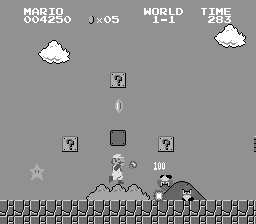

In [64]:
X = rgb2gray (imread ('imgs/Mario_Bros.png'));
imshow(X);
sX = size(X);

In [29]:
function [enc, dic] = mov2frontenco( X, dic )
% move-to-front encoder
% enc = mov2frontenco(X, dic)
% [enc, dic] = mov2frontenco(X)

  if nargin < 2, dic = unique (X(:)); endif

  enc = [];
  for i = 1 : length(X),
    id = find( dic == X(i) );
    enc = [enc; id-1];
    dic(id) = [];
    dic = [X(i); dic];
  endfor

endfunction

In [28]:
function X = mov2frontdeco( enc, dic )
% move-to-front decoder
% X = mov2frontdeco( enc, dic )

  X = [];
  for i = 1:length(enc),
     X = [X; dic(enc(i)+1)];
     dic(enc(i)+1) = [];
     dic = [X(end); dic];
  endfor

endfunction

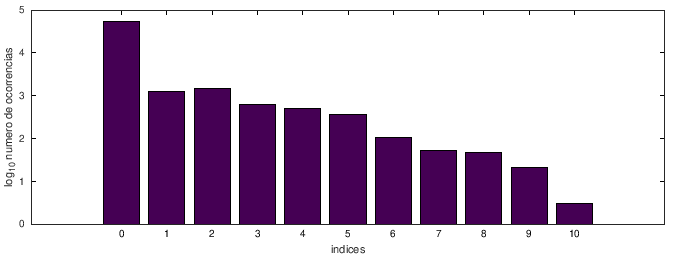

In [46]:
[enc, dic] = mov2frontenco( X(:) );
maxe = max(enc);
[nn, xx] = hist(enc,[0:maxe]);
figure("position",get(0,"screensize")./[1 1 2 3]);
bar(xx, log10(nn)); ylabel('log_{10} numero de ocorrencias'); xlabel('indices');

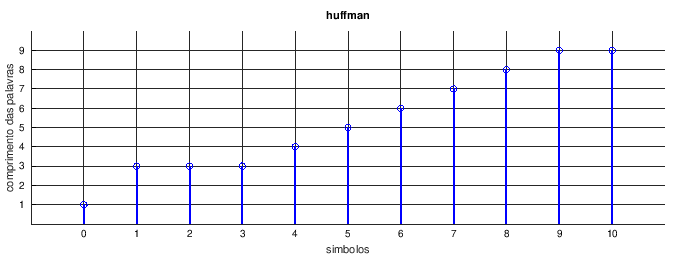

In [120]:
pkg load communications
% maximum likelihood estimation of the distribution
p = nn./sum(nn);
hdic = huffmandict([0:maxe], p);
len = []; for i = 1:length(hdic), len(i)=length(hdic{i}); endfor;
figure("position",get(0,"screensize")./[1 1 2 3])
stem([0:maxe],len,'b-','linewidth',5); axh=axis; axh(1)=-1; axh(2)=maxe+1; axis(axh);
xlabel('simbolos'); ylabel('comprimento das palavras'); title('huffman');
set(gca,'xtick',[0:maxe]); set(gca,'ytick',[1:max(len)]); grid on;

In [121]:
henc = huffmanenco (enc+1, hdic);
nbits = length(henc);
nbytes = ceil(nbits/8); % number of bytes required
henc = [henc zeros(1,nbytes*8-nbits)]; % pad with zeros to make it a multiple of 8
henc = reshape(henc,nbytes,8); % arrange each byte in a row 

In [105]:
# write huffman dictionary as a string
shdic = '';
for i = 1:length(hdic),
  s = num2str(hdic{i});
  s = s(s ~= ' ');
  shdic = cstrcat(shdic,s,';');
endfor;
shdic=shdic(1:end-1);
shdic

shdic = 1;001;000;011;0101;01001;010001;0100001;01000001;010000000;010000001


Vamos agora armazenar em um arquivo binário os dados necessários para reconstruir a imagem original. Para ser ossóvel realziar a reconstrução, precisaremos armazenar também o tamanho da imagem original e o número de bits total da codificação huffman.

In [122]:
filename = '/tmp/mario.mfh';
fid = fopen (filename,'w');
fprintf (fid,'# m2fh\n%d %d\n%d\n',sX,nbits); % write a header with format name, image size and number of bits used
fprintf (fid,'%s\n',shdic);
fwrite (fid, uint8( bi2de (henc) ), 'uint8'); % write image data
fclose(fid);
dr = dir('/tmp/mario.mfh');
printf ('%s has %d bytes\ncompression ratio = %.2f', dr.name, dr.bytes, prod(sX)/dr.bytes);

mario.mfh has 8620 bytes
compression ratio = 6.65
compression ratio = 6.65


Agora vamos ler o arquivo binário e recuperar a imagem.

In [147]:
fid = fopen(filename,'r');
header = fgetl (fid);
if strcmp(header,'# m2fh'),
  im_size = str2num(fgetl (fid));
  n_bits = str2num(fgetl (fid));
  s_hdic = strsplit (fgetl (fid), ';');
  data = fread (fid, Inf, 'uint8');
endif
fclose(fid);

h_dic = {};
for i = 1:length(s_hdic),
  h_dic{i} = str2num(regexprep (s_hdic{i},'([01])','$1 '));
endfor

dbv = de2bi(data); % convert back to binary vector
dbv = reshape(dbv, 1, prod(size(dbv)));
dbv = dbv(1:n_bits); % remove padded zeros >>> if we dont cut it might generate warnings and we will need to remove the error entry
back = huffmandeco (dbv, h_dic);
% >> remove comment if you dont store the nbits value
%id_invalid = find(back == -1);
%back(id_invalid) = [];

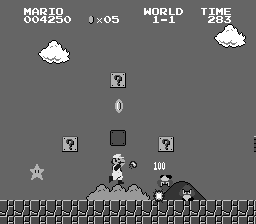

In [146]:
Xr = mov2frontdeco( back-1, [0:255]' );
Xr = reshape(Xr,im_size);
imshow(uint8(Xr));